# Using BERT to detect AI-generated text
In this model , I have attempted to provied a solution to the problem of detection of AI generated text . I have utilised BERT , which is a Natural Language Processing Model and have used the Black box detection approach .

My model is based and backed upon the research paper on "Science of detection of LLM-generated texts by Ruixiang Tang, Yu-Neng Chuang, Xia Hu" .

# Some Nuances between AI-generated and Human written text -
1 - Consistency and Repetition:

AI-generated text may exhibit more consistency and repetition since models are trained on large datasets and may learn certain patterns or phrases that are repeated.

2 - Creativity and Originality:

Human-written text tends to be more creative, nuanced, and original, as humans bring unique perspectives, experiences, and emotions to their writing.

3- Understanding of Context:

Human writers often have a deeper understanding of context, cultural nuances, and subtleties, allowing them to create text that is more contextually appropriate.

4- Emotional Tone:

Human-written text may convey emotions, personal experiences, and a genuine tone that reflects the author's feelings, whereas AI-generated text may lack authentic emotional expression.

5- Errors and Inconsistencies.

# Wroking of the Model 
The purpose of this notebook is to participate in the 'LLM: Detect AI generated text' competition. In this competition, participants are tasked with predicting whether a given dataset, consisting of prompts and texts generated by both humans and AI, contains text that was created by an artificial intelligence system.

The Apporach I used to Solve the problem is as follows -

1 - Importing a Data set and using it to train our model , this involves splitting of Data into training and test sets .

2- Checking for the Class Balance.

3- Pre-processing of data , which involves Cleaning and processing of Virtual Data . 

4- Using BERT tokenizer,encoding the preprocessed text to it for input into our detection model.

5- The final steps Involves training of the Model to a high accuracy , Result prediction and storing of the results .



Importing the Necessary Libraries:

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers
from numba import cuda
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

Loading the Data-sets

In [ ]:
train_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
test_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")


In [11]:
# A view of the Data-set given
train_essays

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [12]:
# Explore the training data
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [13]:
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


Class Balance

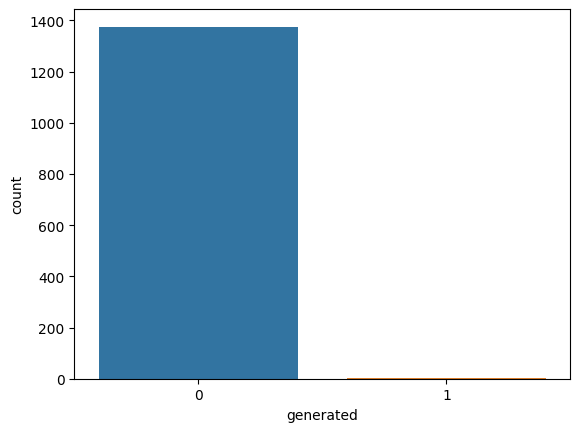

In [14]:
sns.countplot( data= train_essays, x='generated')
plt.show()


Preprocessing of the Data

In [15]:
#preprocessing of the data involves removing puncuations , conversion ino lowercase and removal o stop words.
stop_words = set(stopwords.words('english'))

def preprocess_text(input_text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', input_text)
    
    # Tokenize the text
    words = text.split()
    
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    
    # Convert words to lowercase and filter out non-alphabetic words
    words = [word.lower() for word in words if word.isalpha()]
    
    # Join the processed words back into a string
    processed_text = ' '.join(words)
    
    return processed_text

train_essays['clean_text'] = train_essays['text'].apply(preprocess_text)

Average and max length of the dataset provided:

In [16]:
average_length = np.mean(train_essays['clean_text'].apply(lambda x: len(x.split())))
print("Average length of essays after the cleaning of the dataset is", average_length)


Average length of essays after the cleaning of the dataset is 287.77721335268507


In [17]:
max_length = max(train_essays['clean_text'].apply(lambda x: len(x.split())))
print("Maximum length of essays after the cleaning of the dataset is", max_length)

Maximum length of essays after the cleaning of the dataset is 880


Splitting the data in training and Test-sets.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_essays['clean_text'], train_essays['generated'], test_size=0.2, random_state=42)

In [19]:
# Tokenizing and Encoding  BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')

Converting Labels to tensors and making tensor Data-sets

In [21]:
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [22]:
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)

In [24]:
#Enabling Bert model for sequential Classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [25]:
# Defining optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 10

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}")

Epoch 1/10, Average Training Loss: 0.01
Epoch 2/10, Average Training Loss: 0.01
Epoch 3/10, Average Training Loss: 0.01
Epoch 4/10, Average Training Loss: 0.00
Epoch 5/10, Average Training Loss: 0.00
Epoch 6/10, Average Training Loss: 0.00
Epoch 7/10, Average Training Loss: 0.00
Epoch 8/10, Average Training Loss: 0.00
Epoch 9/10, Average Training Loss: 0.00
Epoch 10/10, Average Training Loss: 0.00


In [26]:
# Validation loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())


Calculation of Validation accuracy

In [28]:
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Validation Accuracy: 1.00


In [33]:
# Test data processing
test_inputs = tokenizer(test_essays['text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Movint the input tensor to the same device as the model
test_inputs =  {key: value.to(device) for key, value in test_inputs.items()}

# Generate predictions using your trained model
with torch.no_grad():
    outputs = model(**test_inputs)
    logits = outputs.logits

# Assuming the first column of logits corresponds to the negative class (non-AI-generated) 
# and the second column corresponds to the positive class (AI-generated)
predictions = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Move predictions back to CPU


Saving and Viewing the Final results

In [32]:
LLM_Results = pd.DataFrame({
    'id': test_essays['id'],
    'generated': predictions
})

# Save the submission DataFrame to a CSV file
LLM_Results.to_csv('/kaggle/working/submission.csv', index=False)

A lookout at the Final Results :

In [35]:
LLM_Results

,id,generated
0,0000aaaa,0.375395
1,1111bbbb,0.392151
2,2222cccc,0.414983
